# DIA Time Series

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.graphics import tsaplots
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import math

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
DIA = pd.read_csv('DIA (3).csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
DIA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1257 non-null   object 
 1   Open       1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Close      1257 non-null   float64
 5   Adj Close  1257 non-null   float64
 6   Volume     1257 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [4]:
DIA.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2015,178.649994,179.229996,176.979996,177.940002,153.454803,4997200
1,1/5/2015,177.059998,177.210007,174.460007,174.839996,150.781387,6700200
2,1/6/2015,175.100006,175.539993,172.320007,173.389999,149.530914,10131400
3,1/7/2015,174.850006,175.789993,174.240005,175.589996,151.428162,5547000
4,1/8/2015,177.259995,178.960007,177.210007,178.759995,154.161942,7166700


Checking the columns of our data.

In [5]:
DIA.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

Checking out the data types of our columns.

In [6]:
DIA.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Check whether there are any null values. 

In [7]:
DIA.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### 2b. Type conversions 

In [8]:
DIA['Date'] = pd.to_datetime(DIA['Date'])
DIA.set_index('Date', inplace=True)

In [9]:
df1=DIA.reset_index()['Close']

In [10]:
df1.head()

0    177.940002
1    174.839996
2    173.389999
3    175.589996
4    178.759995
Name: Close, dtype: float64

Perfect! 

In [11]:
### 2c. Making a predictor variable `y`

In [12]:
y = DIA['Close']

Check the type of our new variable. 

In [13]:
type(y)

pandas.core.series.Series

### 2d. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [14]:
df1.describe()

count    1257.000000
mean      217.267924
std        37.236868
min       156.490005
25%       179.779999
50%       213.990005
75%       253.100006
max       286.329987
Name: Close, dtype: float64

### 2e. Plotting `y`

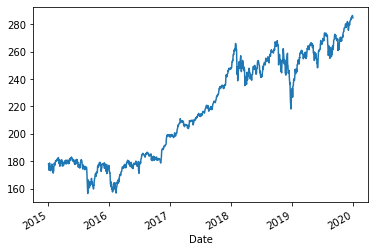

In [15]:
# Visualizing the data
_ = y.plot()

In [16]:
split=int(len(df1) * 0.65)
train, test = df1[0:split], df1[split:len(df1)]

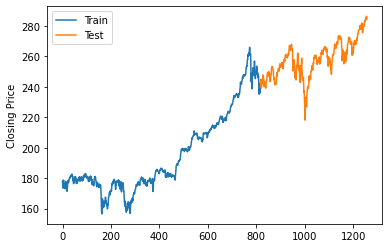

In [17]:
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
train.plot(ax=ax)
test.plot(ax=ax)
ax.legend(["Train", "Test"])
ax.set_ylabel('Closing Price')
plt.show()

## 3. Modelling 

### 3a. Testing for stationarity with KPSS

In [18]:
from statsmodels.tsa.stattools import kpss
kpss(y)

C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(5.117521748333092,
 0.01,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3b. Making the data stationary 

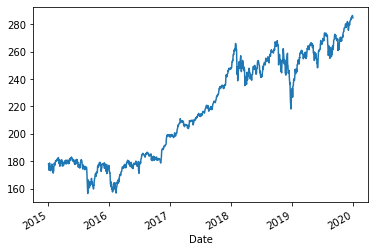

In [19]:
_ = y.plot()

In our plot, we can see that both the mean and the variance as time increases. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). We can get rid of the chaning variance with taking the natural log of the values.

In [20]:
y_log = np.log(y)

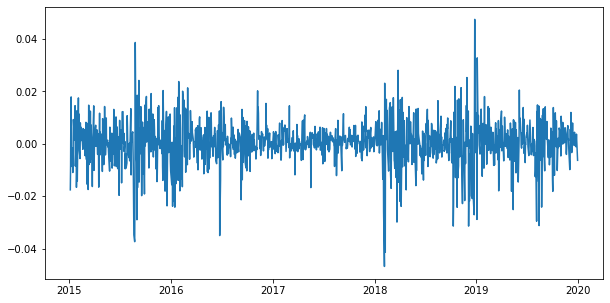

In [21]:
_ = plt.figure(figsize=(10,5))
_ = plt.plot(y_log.diff())

We now take the difference to get a common mean of our times series data.

In [22]:
kpss(y_log.diff().dropna())

C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.08885822300405215,
 0.1,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Autoregressive Integrated Moving Average

In [23]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#### 3di. Mak inga function to find the MSE of a single ARIMA model

In [24]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Making a function to evaluate the different ARIMA models with different p, d, and q values

In [25]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [26]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_log, p_values, d_values, q_values)

So the best p,d, q, parameters for our ARIMA model are 1, 1, 1 respectively. Now we know this, we can build the model.

In [27]:
p=1
d=1
q=1
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(12)

C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\yorik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [28]:
# summary of the data
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1256
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4200.087
Method:                       css-mle   S.D. of innovations              0.009
Date:                Mon, 15 Nov 2021   AIC                          -8392.174
Time:                        12:59:50   BIC                          -8371.631
Sample:                             1   HQIC                         -8384.453
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      2.753      0.006       0.000       0.001
ar.L1.D.Close     0.9613      0.021     45.106      0.000       0.920       1.003
ma.L1.D.Close    -0.9786      0.016    -62.786      0.000      -1.009      -0.948
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0402           +0.0000j            1.0402            0.0000
MA.1            1.0219           +0.0000j            1.0219            0.0000
-----------------------------------------------------------------------------
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

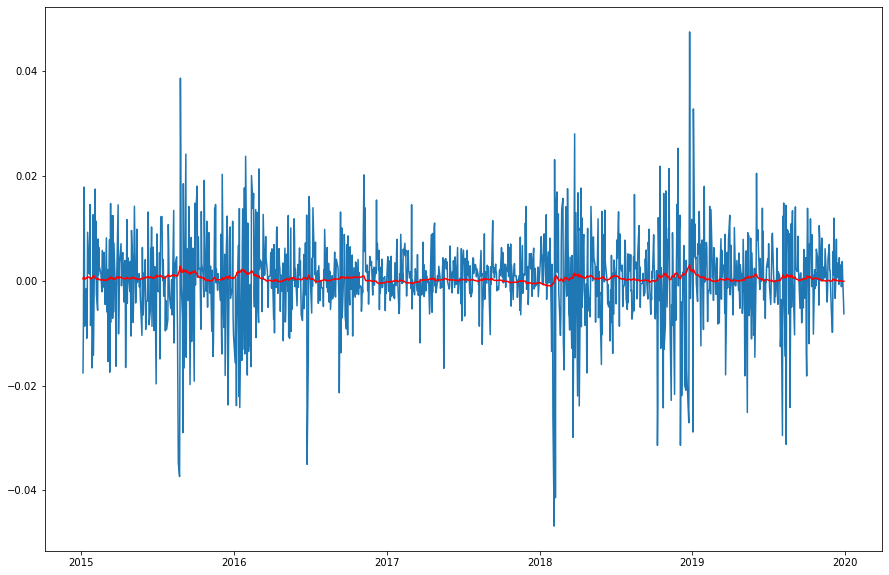

In [29]:
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(y_log.diff())
plt.plot(model_fit.predict(), color = 'red')

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

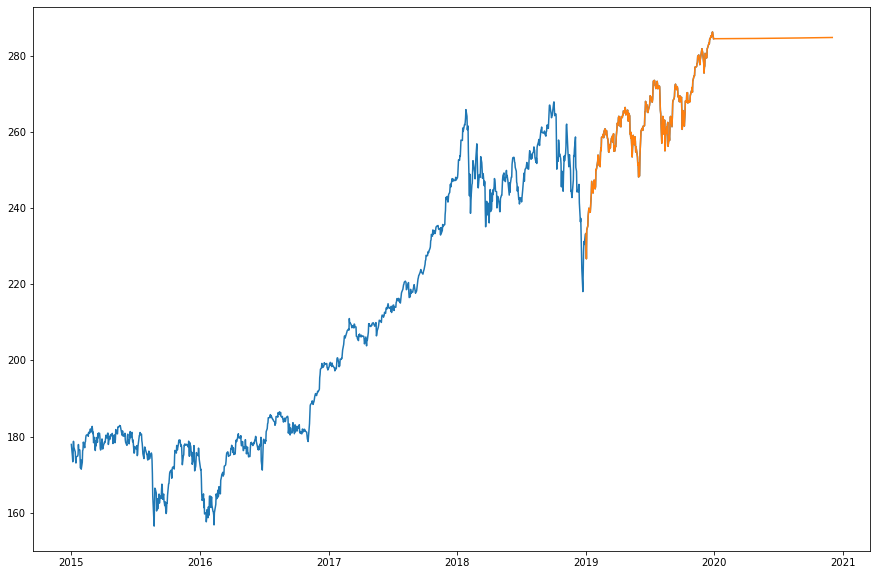

In [30]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 12
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, \
                           freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Date'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Date'] = pd.to_datetime(future_months['Date'])
future_months.set_index('Date', inplace = True)
future_months['Prediction'] = forecast[0]

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y)
plt.plot(y['2019'].append(np.exp(future_months['Prediction'])))
plt.show()

### 3f. The LSTM Model

In [31]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [32]:
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [33]:
training_size,test_size

(1005, 252)

In [34]:
train_data

array([[0.16520333],
       [0.14132774],
       [0.13016017],
       ...,
       [0.55622314],
       [0.5758626 ],
       [0.56985522]])

In [35]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [36]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [37]:
print(X_train.shape), print(y_train.shape)

(904, 100)
(904,)


(None, None)

In [38]:
print(X_test.shape), print(ytest.shape)

(151, 100)
(151,)


(None, None)

In [39]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [40]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [41]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 7s 232ms/step - loss: 0.0691 - val_loss: 0.0927
Epoch 2/100
15/15 [==============================] - 2s 148ms/step - loss: 0.0119 - val_loss: 0.0036
Epoch 3/100
15/15 [==============================] - 2s 146ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 4/100
15/15 [==============================] - 2s 145ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 5/100
15/15 [==============================] - 2s 151ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 6/100
15/15 [==============================] - 2s 146ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 7/100
15/15 [==============================] - 2s 142ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 8/100
15/15 [==============================] - 2s 149ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 9/100
15/15 [==============================] - 2s 152ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 10/100
15/15 [==============================] - 2s 146ms/step - loss: 0.0014 - val_lo

15/15 [==============================] - 2s 161ms/step - loss: 5.1726e-04 - val_loss: 8.7829e-04
Epoch 80/100
15/15 [==============================] - 2s 158ms/step - loss: 4.9650e-04 - val_loss: 0.0019
Epoch 81/100
15/15 [==============================] - 2s 153ms/step - loss: 6.3179e-04 - val_loss: 6.7542e-04
Epoch 82/100
15/15 [==============================] - 2s 159ms/step - loss: 6.0065e-04 - val_loss: 0.0023
Epoch 83/100
15/15 [==============================] - 2s 158ms/step - loss: 5.0507e-04 - val_loss: 0.0015
Epoch 84/100
15/15 [==============================] - 2s 161ms/step - loss: 5.0212e-04 - val_loss: 8.1825e-04
Epoch 85/100
15/15 [==============================] - 3s 172ms/step - loss: 4.5323e-04 - val_loss: 0.0019
Epoch 86/100
15/15 [==============================] - 3s 172ms/step - loss: 4.7904e-04 - val_loss: 8.7684e-04
Epoch 87/100
15/15 [==============================] - 2s 162ms/step - loss: 4.4133e-04 - val_loss: 0.0028
Epoch 88/100
15/15 [=======================

In [42]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [43]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [44]:
math.sqrt(mean_squared_error(y_train,train_predict))

211.39995723701938

In [45]:
math.sqrt(mean_squared_error(ytest,test_predict))

266.46339441431763

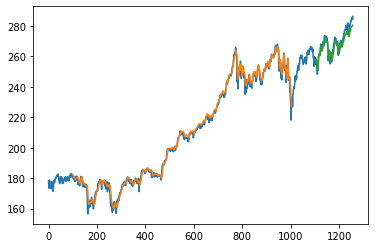

In [46]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [47]:
len(test_data)

252

In [48]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 0)

In [49]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [50]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

ValueError: cannot reshape array of size 0 into shape (1,100,1)

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

In [ ]:
plt.plot(df3)